In [10]:
import tensorflow as tf
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import preprocess_input
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [3]:
training_set = train_datagen.flow_from_directory('../../Covid19-dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 251 images belonging to 3 classes.


In [4]:
test_set = test_datagen.flow_from_directory('../../Covid19-dataset/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 66 images belonging to 3 classes.


In [5]:
model = load_model('../../models/covid/covid_vgg1.h5')

In [6]:
test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

3/3 [==============================] - 26s 6s/step - loss: 0.0872 - accuracy: 0.9697
Test Loss: 0.08715351670980453, Test Accuracy: 0.9696969985961914


In [8]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

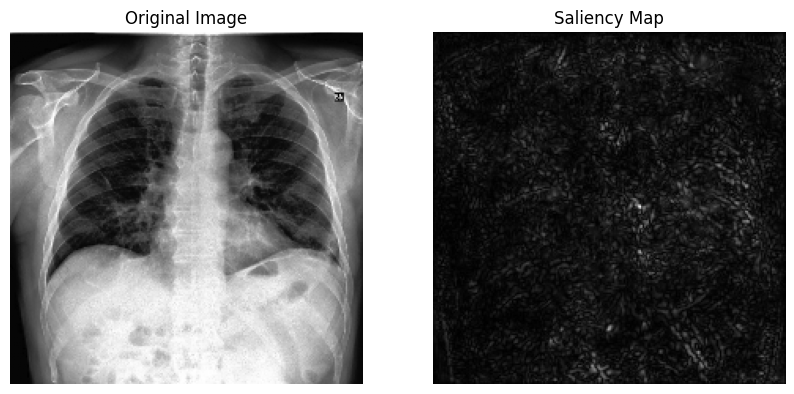

In [17]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def visualize_saliency_map(model, image_path, output_image_path):
    img = preprocess_image(image_path)
    img_tensor = tf.convert_to_tensor(img)  # Convert the NumPy array to a TensorFlow tensor
    
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        loss = tf.keras.backend.max(predictions, axis=1)
    
    gradients = tape.gradient(loss, img_tensor)
    saliency_map = np.max(np.abs(gradients.numpy()), axis=-1)[0]

    # Normalize the saliency map
    saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))

    # Visualize the original image and the saliency map
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap='gray')
    plt.title('Saliency Map')
    plt.axis('off')

    saliency_map_path = os.path.join(output_image_path, 'saliency_map.png')

    plt.subplot(1, 2, 2)
    plt.savefig(saliency_map_path)

    plt.show()


# Replace 'path/to/image.jpg' with the path to the image you'd like to visualize
input_image_path = '../../Covid19-dataset/test/Covid/0100.jpeg'
output_image_path = '../../Output_Images/saliency_map/'
visualize_saliency_map(model, input_image_path, output_image_path)